In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
mean1, mean2 = np.array([-1, 2]), np.array([1, -1])
mean3, mean4 = np.array([4, -4]), np.array([-4, 4])
covar = np.array([[1.0, 0.8], [0.8, 1.0]])
X1 = np.random.multivariate_normal(mean1, covar, 50)
X1 = np.vstack((X1, np.random.multivariate_normal(mean3, covar, 50)))
y1 = np.ones(X1.shape[0])
X2 = np.random.multivariate_normal(mean2, covar, 50)
X2 = np.vstack((X2, np.random.multivariate_normal(mean4, covar, 50)))
y2 = -1 * np.ones(X2.shape[0])
X_train = np.vstack((X1[:80], X2[:80]))
y_train = np.hstack((y1[:80], y2[:80]))
X_test = np.vstack((X1[80:], X2[80:]))
y_test = np.hstack((y1[80:], y2[80:]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 2) (160,) (40, 2) (40,)


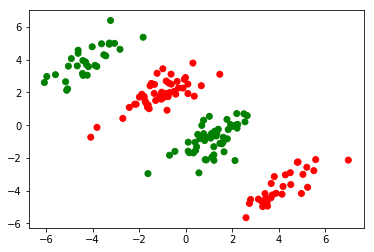

In [4]:
# 设置颜色参数
colors = {1:'r', -1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=pd.Series(y_train).map(colors))
plt.show();

In [9]:
### 定义高斯核函数
def gaussian_kernel(x1, x2, sigma=5.0):
    '''
    输入:
    x1: 向量1
    x2: 向量2
    输出:
    两个向量的高斯核
    '''
    return np.exp(-1 * np.linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

In [10]:
from cvxopt import matrix, solvers

### 定义线性不可分支持向量机
### 借助于高斯核函数转化为线性可分的情形
class Non_Linear_SVM:
    ### 定义基本参数
    def __init__(self, kernel=gaussian_kernel):
        # 非线性可分svm核函数，默认为高斯核函数
        self.kernel = kernel
    
    ### 定义非线性可分支持向量机拟合方法
    def fit(self, X, y):
        # 训练样本数和特征数
        m, n = X.shape
        
        # 基于线性核计算Gram矩阵
        K = self._gram_matrix(X)
                
        # 初始化二次规划相关变量：P/q/A/b/G/h
        P = matrix(np.outer(y,y) * K)
        q = matrix(np.ones(m) * -1)
        A = matrix(y, (1, m))
        b = matrix(0.0)
        G = matrix(np.diag(np.ones(m) * -1))
        h = matrix(np.zeros(m))

        # 构建二次规划求解
        sol = solvers.qp(P, q, G, h, A, b)
        # 拉格朗日乘子
        a = np.ravel(sol['x'])

        # 寻找支持向量
        spv = a > 1e-5
        ix = np.arange(len(a))[spv]
        self.a = a[spv]
        self.spv = X[spv]
        self.spv_y = y[spv]
        print('{0} support vectors out of {1} points'.format(len(self.a), m))

        # 截距向量
        self.b = 0
        for i in range(len(self.a)):
            self.b += self.spv_y[i]
            self.b -= np.sum(self.a * self.spv_y * K[ix[i], spv])
        self.b /= len(self.a)

        # 权重向量
        self.w = None

    ### 定义Gram矩阵计算函数
    def _gram_matrix(self, X):
        m, n = X.shape
        K = np.zeros((m, m))
        # 遍历计算Gram矩阵
        for i in range(m):
            for j in range(m):
                K[i,j] = self.kernel(X[i], X[j])
        return K
    
    ### 定义映射函数
    def project(self, X):
        y_pred = np.zeros(len(X))
        for i in range(X.shape[0]):
            s = 0
            for a, spv_y, spv in zip(self.a, self.spv_y, self.spv):
                s += a * spv_y * self.kernel(X[i], spv)
            y_pred[i] = s
        return y_pred + self.b
    
    ### 定义模型预测函数
    def predict(self, X):
        return np.sign(self.project(X))

In [11]:
# 导入sklearn准确率评估函数
from sklearn.metrics import accuracy_score
# 创建非线性可分支持向量机模型实例
non_linear_svm = Non_Linear_SVM()
# 模型拟合
non_linear_svm.fit(X_train, y_train)
# 模型预测
y_pred = non_linear_svm.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on cvxopt: ', 
      accuracy_score(y_test, y_pred))

     pcost       dcost       gap    pres   dres
 0: -5.3110e+01 -1.6223e+02  4e+02  2e+01  2e+00
 1: -8.0716e+01 -1.8786e+02  2e+02  5e+00  7e-01
 2: -1.0556e+02 -1.9757e+02  1e+02  3e+00  4e-01
 3: -1.7380e+02 -2.7165e+02  1e+02  3e+00  4e-01
 4: -2.4244e+02 -2.8787e+02  6e+01  9e-01  1e-01
 5: -2.5720e+02 -2.6511e+02  9e+00  1e-01  1e-02
 6: -2.6014e+02 -2.6216e+02  2e+00  1e-02  2e-03
 7: -2.6162e+02 -2.6165e+02  3e-02  2e-04  2e-05
 8: -2.6164e+02 -2.6164e+02  3e-04  2e-06  2e-07
 9: -2.6164e+02 -2.6164e+02  3e-06  2e-08  2e-09
Optimal solution found.
9 support vectors out of 160 points
Accuracy of soft margin svm based on cvxopt:  1.0


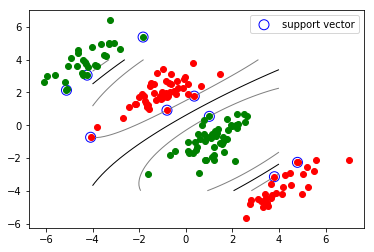

In [12]:
### 绘制非线性可分支持向量机
def plot_classifier(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "go")
    plt.scatter(non_linear_svm.spv[:,0], non_linear_svm.spv[:,1], 
                s=100, c="", edgecolors="b", label="support vector")

    X1, X2 = np.meshgrid(np.linspace(-4,4,50), np.linspace(-4,4,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = non_linear_svm.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.legend()
    plt.show()
    
plot_classifier(X_train[y_train==1], X_train[y_train==-1], non_linear_svm)

In [14]:
from sklearn import svm
# 创建svm模型实例
clf = svm.SVC(kernel='rbf')
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on sklearn: ', 
      accuracy_score(y_test, y_pred))

Accuracy of soft margin svm based on sklearn:  1.0


D:\Installation\anaconda\install\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
